This function shows how to use TensorFlow to solve logistic regression with a multiple layer neural network



$$
\textbf{y} = sigmoid(\textbf{A}_{3} \times sigmoid(\textbf{A}_{2} \times sigmoid(\textbf{A}_{1} \times \textbf{x} + \textbf{b}_{1}) + \textbf{b}_{2}) + \textbf{b}_{3})
$$


We will use the low birth weight data, specifically:

  y = 0 or 1 = low birth weight
  x = demographic and medical history data

In [1]:

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import requests
import os.path
import csv
from tensorflow.python.framework import ops

# reset computational graph
ops.reset_default_graph()

C:\Users\ezarpkm\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
birth_weight_file = 'birth_weight.csv'

# download data and create data file if file does not exist in current directory
if not os.path.exists(birth_weight_file):
    birthdata_url = 'https://github.com/nfmcclure/tensorflow_cookbook/raw/master/01_Introduction/07_Working_with_Data_Sources/birthweight_data/birthweight.dat'
    birth_file = requests.get(birthdata_url)
    birth_data = birth_file.text.split('\r\n')
    birth_header = birth_data[0].split('\t')
    birth_data = [[float(x) for x in y.split('\t') if len(x)>=1] for y in birth_data[1:] if len(y)>=1]
    with open(birth_weight_file, "w") as f:
        writer = csv.writer(f)
        writer.writerows(birth_data)
        f.close()

# read birth weight data into memory
birth_data = []
with open(birth_weight_file, newline='') as csvfile:
     csv_reader = csv.reader(csvfile)
     birth_header = next(csv_reader)
     for row in csv_reader:
         birth_data.append(row)

birth_data = [[float(x) for x in row] for row in birth_data]

# Pull out target variable
y_vals = np.array([x[0] for x in birth_data])
# Pull out predictor variables (not id, not target, and not birthweight)
x_vals = np.array([x[1:8] for x in birth_data])

# set for reproducible results
seed = 99
np.random.seed(seed)
tf.set_random_seed(seed)


In [3]:
batch_size = 90

train_indices = np.random.choice(len(x_vals), round(len(x_vals)*0.8), replace=False)

test_indices = np.array(list(set(range(len(x_vals))) - set(train_indices)))

x_vals_train = x_vals[train_indices]
x_vals_test = x_vals[test_indices]
y_vals_train = y_vals[train_indices]
y_vals_test = y_vals[test_indices]

# Normalize by column (min-max norm)
def normalize_cols(m):
    col_max = m.max(axis=0)
    col_min = m.min(axis=0)
    return (m-col_min) / (col_max - col_min)
    
x_vals_train = np.nan_to_num(normalize_cols(x_vals_train))
x_vals_test = np.nan_to_num(normalize_cols(x_vals_test))

In [4]:
sess = tf.Session()

# Initialize placeholders
x_data = tf.placeholder(shape=[None, 7], dtype=tf.float32)
y_target = tf.placeholder(shape=[None, 1], dtype=tf.float32)


# Create variable definition
def init_variable(shape):
    return(tf.Variable(tf.random_normal(shape=shape)))


#creating logistic function

def logistic(input_layer, multiplication_weight, bias_weight, activation = True):
    linear_layer = tf.add(tf.matmul(input_layer, multiplication_weight), bias_weight)
    if activation:
        return(tf.nn.sigmoid(linear_layer))
    else:
        return(linear_layer)

# First logistic layer

A1 = init_variable(shape = [7,14])
b1 = init_variable(shape = [14])
log_layer1 = logistic(x_data, A1, b1)

#Second logistic layer
A2 = init_variable(shape = [14,5])
b2 = init_variable(shape = [5])
log_layer2 = logistic(log_layer1, A2, b2)

#final layer

A3 = init_variable(shape =[5,1])
b3 = init_variable(shape = [1])
final_output = logistic(log_layer2, A3, b3, activation= False)


loss = tf.reduce_mean(tf.abs(y_target - final_output))

my_opt = tf.train.AdamOptimizer(0.0002)
train_step = my_opt.minimize(loss)

In [5]:
init = tf.global_variables_initializer()
sess.run(init)

In [6]:
prediction = tf.round(tf.nn.sigmoid(final_output))
correct_predictions = tf.cast(tf.equal(y_target, prediction), tf.float32)
accuracy = tf.reduce_mean(correct_predictions)


#loop
loss_vec = []
train_acc = []
test_acc = []

for i in range(1500):
    rand_index = np.random.choice(len(x_vals_train), size = batch_size)
    rand_x = x_vals_train[rand_index]
    rand_y = np.transpose([y_vals_train[rand_index]])
    sess.run(train_step, feed_dict={x_data: rand_x, y_target: rand_y})
    
    temp_loss = sess.run(loss, feed_dict={x_data: rand_x, y_target: rand_y})
    loss_vec.append(temp_loss)
    
    temp_train_accuracy = sess.run(accuracy, feed_dict={x_data: x_vals_train, 
                                                        y_target: np.transpose([y_vals_train])})
    train_acc.append(temp_train_accuracy)
    
    temp_test_accuracy = sess.run(accuracy, feed_dict={x_data: x_vals_test, 
                                                        y_target: np.transpose([y_vals_test])})
    
    test_acc.append(temp_test_accuracy)
    if (i+1)%150==0:
        print('Loss = ' + str(temp_loss))

Loss = 1.1782118
Loss = 0.8135015
Loss = 0.65426093
Loss = 0.5545172
Loss = 0.53660923
Loss = 0.41048932
Loss = 0.38255933
Loss = 0.44293672
Loss = 0.37158525
Loss = 0.33682936


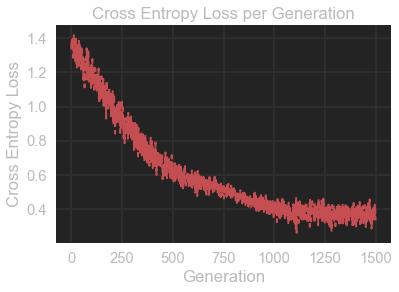

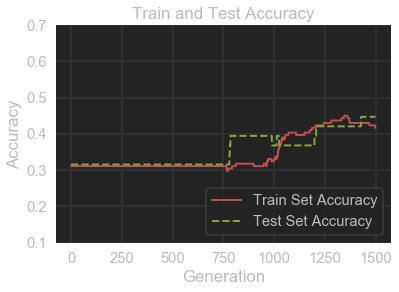

In [9]:
from jupyterthemes import jtplot
jtplot.style(context='talk', fscale=1.4, spines=False, gridlines='-')
%matplotlib inline
# Plot loss over time
plt.plot(loss_vec, 'r--')
plt.title('Cross Entropy Loss per Generation')
plt.xlabel('Generation')
plt.ylabel('Cross Entropy Loss')
plt.show()

# Plot train and test accuracy
plt.plot(train_acc, 'r-', label='Train Set Accuracy')
plt.plot(test_acc, 'g--', label='Test Set Accuracy')
plt.title('Train and Test Accuracy')
plt.ylim([0.1,0.7])
plt.xlabel('Generation')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()